In [9]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import random
import tensorflow as tf
#from google.colab import drive


# Exploratory Data Analysis (EDA):

In [10]:
#drive.mount('/content/drive')

In [11]:
Train = 'train'
Test = 'test'

In [12]:
def plt_img (dataset_path):
    class_folders = os.listdir(dataset_path)

# Set the number of images to visualize for each class
    num_images_per_class =5

    # Create a grid of subplots
    fig, axes = plt.subplots(len(class_folders), num_images_per_class, figsize=(15, 8))

    for i, class_folder in enumerate(class_folders):
        class_path = os.path.join(dataset_path, class_folder)

        # List all images in the class folder
        images = os.listdir(class_path)

        # Randomly select images for visualization
        selected_images = random.sample(images, num_images_per_class)

        for j, image_file in enumerate(selected_images):
            image_path = os.path.join(class_path, image_file)

            # Load and display the image
            img = Image.open(image_path)

            # Display the image on the corresponding subplot
            axes[i, j].imshow(img)
            axes[i, j].set_title(f'Class: {image_file}')
            axes[i, j].axis('off')

    # Adjust layout to prevent overlapping
    plt.tight_layout()
    plt.show()

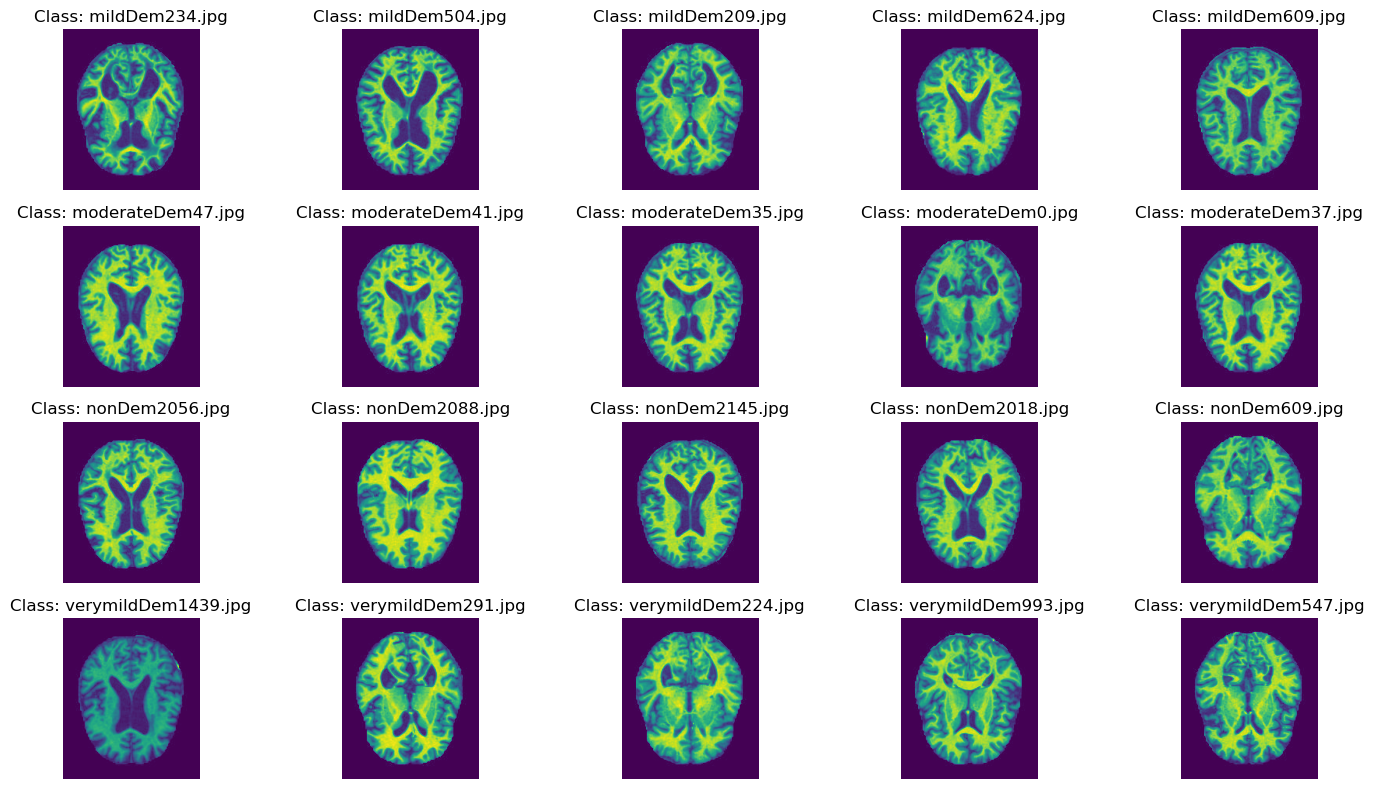

In [13]:
plt_img(Train)

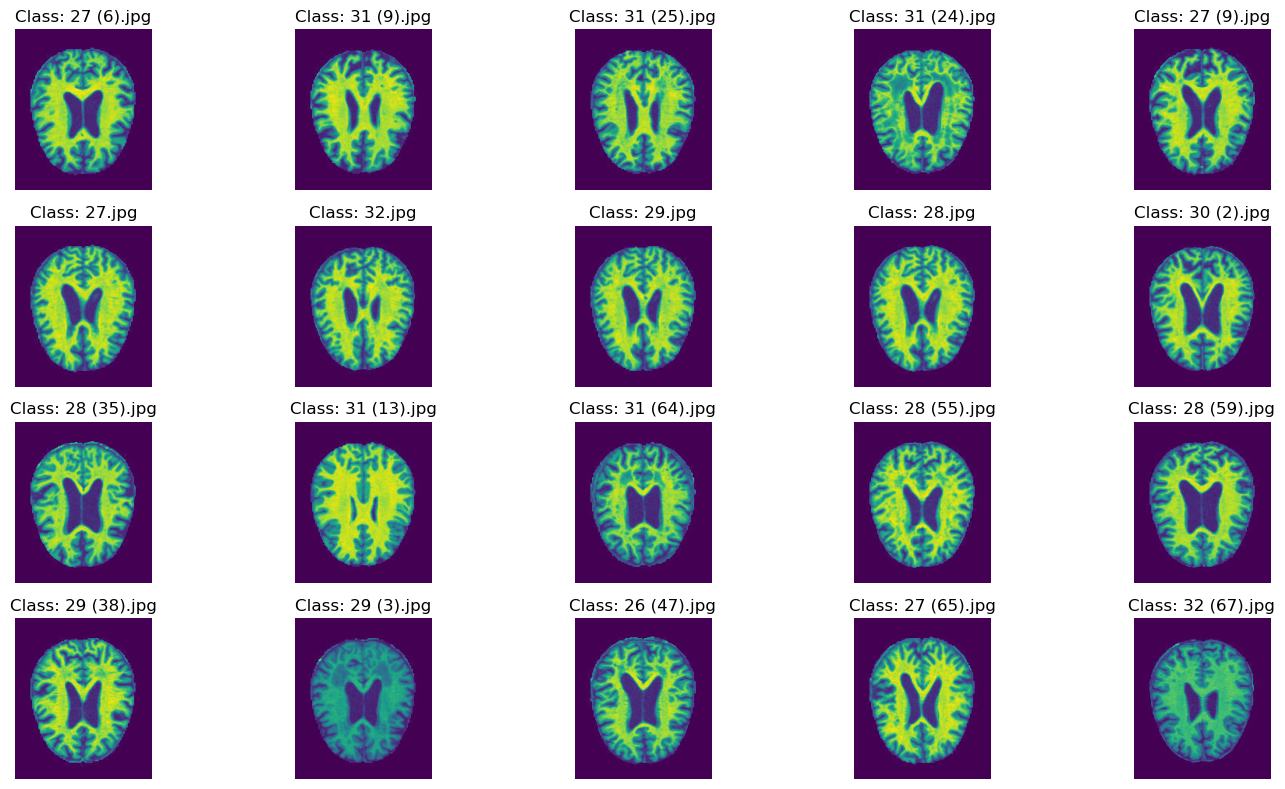

In [14]:
plt_img(Test)

#Data Preprocessing

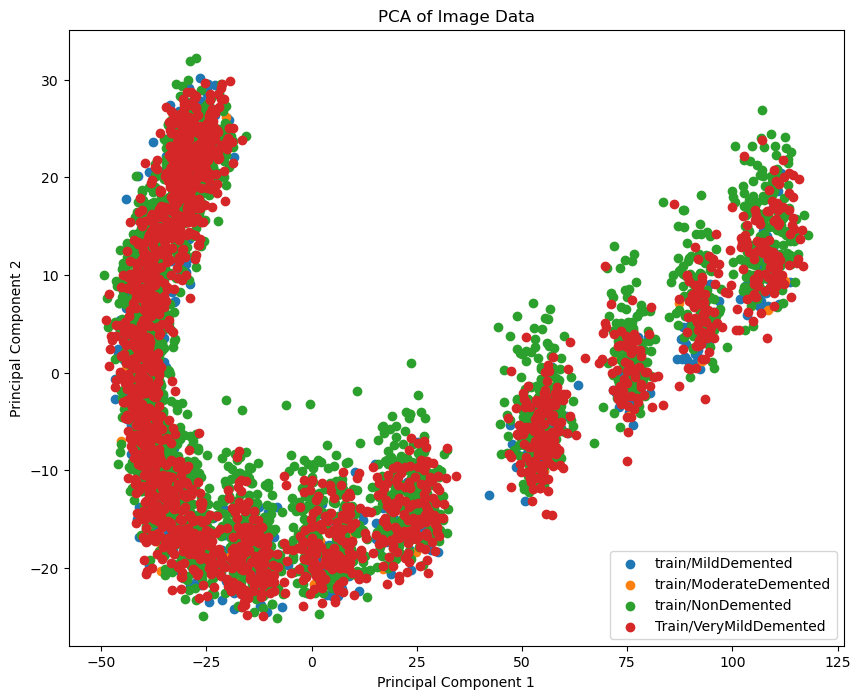

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import io, color, exposure, transform

# Function to load and preprocess images
def load_and_preprocess(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder, filename))
        img = exposure.equalize_hist(img)  # Enhance contrast
        img = transform.resize(img, (64, 64))  # Resize for consistency
        images.append(img.flatten())  # Flatten the image to a 1D array
    return np.array(images)

# Specify the path to your training data folders for each class
class_folders = ['train/MildDemented', 'train/ModerateDemented',
                 'train/NonDemented', 'Train/VeryMildDemented']

# Load and preprocess images for each class
class_data = [load_and_preprocess(folder) for folder in class_folders]

# Combine data from all classes
X = np.vstack(class_data)

# Standardize the data
X_std = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_std)

# Create a DataFrame for visualization (optional)
import pandas as pd
df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df['Class'] = np.repeat(class_folders, [len(data) for data in class_data])

# Visualize the results
plt.figure(figsize=(10, 8))
for class_folder in class_folders:
    plt.scatter(
        df.loc[df['Class'] == class_folder, 'PC1'],
        df.loc[df['Class'] == class_folder, 'PC2'],
        label=class_folder
    )
plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


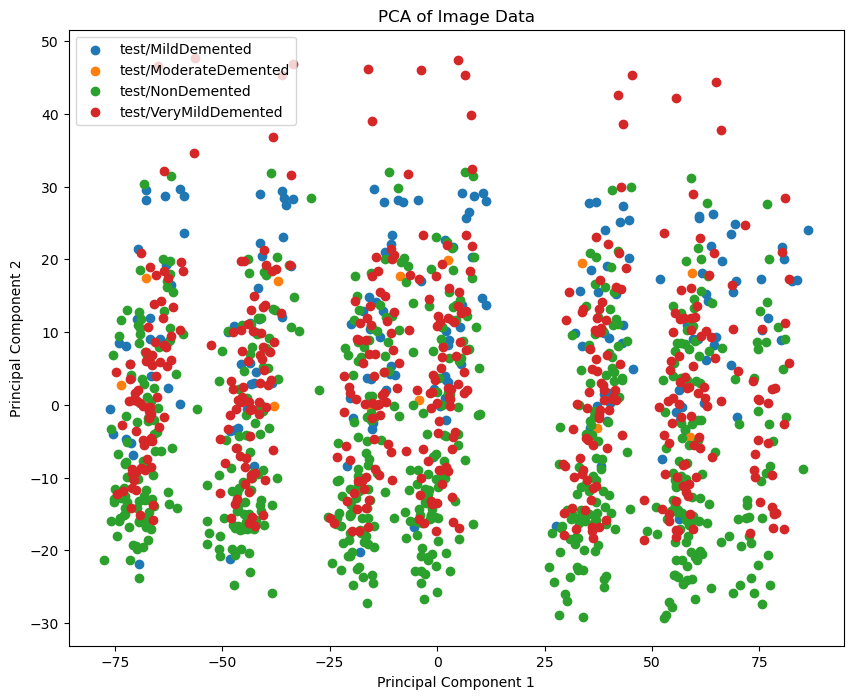

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage import io, color, exposure, transform

# Function to load and preprocess images
def load_and_preprocess(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder, filename))
        img = exposure.equalize_hist(img)  # Enhance contrast
        img = transform.resize(img, (64, 64))  # Resize for consistency
        images.append(img.flatten())  # Flatten the image to a 1D array
    return np.array(images)

# Specify the path to your training data folders for each class
class_folders = ['test/MildDemented', 'test/ModerateDemented',
                 'test/NonDemented', 'test/VeryMildDemented']

# Load and preprocess images for each class
class_data = [load_and_preprocess(folder) for folder in class_folders]

# Combine data from all classes
X = np.vstack(class_data)

# Standardize the data
X_std = StandardScaler().fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_std)

# Create a DataFrame for visualization (optional)
import pandas as pd
df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df['Class'] = np.repeat(class_folders, [len(data) for data in class_data])

# Visualize the results
plt.figure(figsize=(10, 8))
for class_folder in class_folders:
    plt.scatter(
        df.loc[df['Class'] == class_folder, 'PC1'],
        df.loc[df['Class'] == class_folder, 'PC2'],
        label=class_folder
    )
plt.title('PCA of Image Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


#Model Selection and Training

##Transfer Learning Model

In [17]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your dataset
dataset_path = Train


# Define image and model parameters
img_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model for fine-tuning
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes based on your dataset

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an ImageDataGenerator for loading and augmenting the training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Adjust based on your dataset
    shuffle=True
)

# Fine-tune the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10  # Adjust the number of epochs based on your needs
)

# Save the fine-tuned model
model.save('alzheimer_fine_tuned_model.h5')

c:\Users\jaden\anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 5121 images belonging to 4 classes.
Epoch 1/10
160/160 [==============================] - 71s 392ms/step - loss: 1.0783 - accuracy: 0.4913
Epoch 2/10
160/160 [==============================] - 63s 395ms/step - loss: 0.9874 - accuracy: 0.5262
Epoch 3/10
160/160 [==============================] - 61s 382ms/step - loss: 0.9638 - accuracy: 0.5286
Epoch 4/10
160/160 [==============================] - 62s 388ms/step - loss: 0.9517 - accuracy: 0.5477
Epoch 5/10
160/160 [==============================] - 61s 379ms/step - loss: 0.9475 - accuracy: 0.5392
Epoch 6/10
160/160 [==============================] - 60s 372ms/step - loss: 0.9345 - accuracy: 0.5461
Epoch 7/10
160/160 [==============================] - 60s 372ms/step - loss: 0.9318 - accuracy: 0.5508
Epoch 8/10
160/160 [==============================] - 59s 370ms/step - loss: 0.9094 - accuracy: 0.5579
Epoch 9/10
160/160 [==============================] - 59s 370ms/step - loss: 0.9144 - accuracy: 0.5573
Epoch 10/10
160/160 [==========

In [18]:
dataset_Test = Test

train_generator = train_datagen.flow_from_directory(
    dataset_Test,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',  # Adjust based on your dataset
    shuffle=True
)

# Fine-tune the model
model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10  # Adjust the number of epochs based on your needs
)
model.save('alzheimer_fine_tuned_model_test.h5')

Found 1279 images belonging to 4 classes.
Epoch 1/10
39/39 [==============================] - 18s 454ms/step - loss: 0.9360 - accuracy: 0.5269
Epoch 2/10
39/39 [==============================] - 15s 373ms/step - loss: 0.9377 - accuracy: 0.5557
Epoch 3/10
39/39 [==============================] - 15s 371ms/step - loss: 0.9225 - accuracy: 0.5429
Epoch 4/10
39/39 [==============================] - 15s 372ms/step - loss: 0.9223 - accuracy: 0.5525
Epoch 5/10
39/39 [==============================] - 14s 367ms/step - loss: 0.9213 - accuracy: 0.5397
Epoch 6/10
39/39 [==============================] - 14s 363ms/step - loss: 0.9232 - accuracy: 0.5493
Epoch 7/10
39/39 [==============================] - 14s 361ms/step - loss: 0.9033 - accuracy: 0.5573
Epoch 8/10
39/39 [==============================] - 14s 361ms/step - loss: 0.9106 - accuracy: 0.5573
Epoch 9/10
39/39 [==============================] - 14s 362ms/step - loss: 0.8989 - accuracy: 0.5662
Epoch 10/10
39/39 [==============================

In [19]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

def calc_metrics(model,dataset):
    # Load the fine-tuned model
    model = load_model('alzheimer_fine_tuned_model.h5')

    # Assuming you have a test generator for your test dataset
    test_generator = train_datagen.flow_from_directory(
        dataset,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Set to False to ensure predictions align with ground truth
    )

    # Make predictions on the test set
    predictions = model.predict(test_generator)

    # Convert predictions to class labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get true labels
    true_labels = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    # Display the metrics
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}')

    # Display detailed classification report
    print('\nClassification Report:\n', classification_report(true_labels, predicted_labels))

##Custom Deep Neural Network (DNN)

In [20]:
img_size = (224, 224)
batch_size = 32


# Create a custom DNN model
model = Sequential()
model.add(Flatten(input_shape=(224, 224, 3)))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes based on your dataset

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 80% training, 20% validation
)

# Create training and validation generators
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Set to 'training' for the training set
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Set to 'validation' for the validation set
    shuffle=False  # No need to shuffle the validation set
)

# Train the custom DNN
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the trained model
model.save('alzheimer_custom_DNN_model.h5')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Epoch 1/10
128/128 [==============================] - 57s 442ms/step - loss: 2.1242 - accuracy: 0.4100 - val_loss: 1.0912 - val_accuracy: 0.5081
Epoch 2/10
128/128 [==============================] - 56s 438ms/step - loss: 1.2028 - accuracy: 0.4555 - val_loss: 1.1002 - val_accuracy: 0.5020
Epoch 3/10
128/128 [==============================] - 56s 435ms/step - loss: 1.1726 - accuracy: 0.4757 - val_loss: 1.0606 - val_accuracy: 0.5161
Epoch 4/10
128/128 [==============================] - 56s 436ms/step - loss: 1.1503 - accuracy: 0.4626 - val_loss: 1.0273 - val_accuracy: 0.5161
Epoch 5/10
128/128 [==============================] - 55s 431ms/step - loss: 1.1604 - accuracy: 0.4803 - val_loss: 1.0426 - val_accuracy: 0.5161
Epoch 6/10
128/128 [==============================] - 56s 432ms/step - loss: 1.1374 - accuracy: 0.4884 - val_loss: 1.0704 - val_accuracy: 0.5161
Epoch 7/10
128/128 [==========================

In [21]:
train_generator = train_datagen.flow_from_directory(
    dataset_Test,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',  # Set to 'training' for the training set
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_Test,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',  # Set to 'validation' for the validation set
    shuffle=False  # No need to shuffle the validation set
)

# Train the custom DNN
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Save the trained model
model.save('alzheimer_custom_DNN_model_test.h5')

Found 1025 images belonging to 4 classes.
Found 254 images belonging to 4 classes.
Epoch 1/10
32/32 [==============================] - 14s 433ms/step - loss: 1.0687 - accuracy: 0.4975 - val_loss: 1.0451 - val_accuracy: 0.5714
Epoch 2/10
32/32 [==============================] - 14s 428ms/step - loss: 1.0727 - accuracy: 0.4975 - val_loss: 1.0496 - val_accuracy: 0.5714
Epoch 3/10
32/32 [==============================] - 14s 428ms/step - loss: 1.0650 - accuracy: 0.4965 - val_loss: 1.0465 - val_accuracy: 0.5714
Epoch 4/10
32/32 [==============================] - 14s 430ms/step - loss: 1.0690 - accuracy: 0.4955 - val_loss: 1.0469 - val_accuracy: 0.5714
Epoch 5/10
32/32 [==============================] - 14s 429ms/step - loss: 1.0575 - accuracy: 0.5005 - val_loss: 1.0436 - val_accuracy: 0.5714
Epoch 6/10
32/32 [==============================] - 14s 425ms/step - loss: 1.0556 - accuracy: 0.4975 - val_loss: 1.0405 - val_accuracy: 0.5714
Epoch 7/10
32/32 [==============================] - 14s 429

##Student-Designed Model

In [22]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define image and model parameters
img_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes based on your dataset

# Compile the model
model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an ImageDataGenerator for loading and augmenting the training data
train_generator = train_datagen.flow_from_directory(
      dataset_path,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',  # Adjust based on your dataset
      shuffle=True
  )

  # Fine-tune the model
model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=10  # Adjust the number of epochs based on your needs
  )
model.save('alzheimer_student_design_model.h5')
  # Save the fine-tuned model


Found 5121 images belonging to 4 classes.
Epoch 1/10
160/160 [==============================] - 57s 343ms/step - loss: 1.0585 - accuracy: 0.4840
Epoch 2/10
160/160 [==============================] - 55s 346ms/step - loss: 1.0326 - accuracy: 0.5023
Epoch 3/10
160/160 [==============================] - 56s 349ms/step - loss: 0.9960 - accuracy: 0.5184
Epoch 4/10
160/160 [==============================] - 56s 350ms/step - loss: 0.9769 - accuracy: 0.5251
Epoch 5/10
160/160 [==============================] - 56s 349ms/step - loss: 0.9434 - accuracy: 0.5296
Epoch 6/10
160/160 [==============================] - 56s 351ms/step - loss: 0.9426 - accuracy: 0.5410
Epoch 7/10
160/160 [==============================] - 56s 350ms/step - loss: 0.9247 - accuracy: 0.5526
Epoch 8/10
160/160 [==============================] - 57s 358ms/step - loss: 0.9231 - accuracy: 0.5457
Epoch 9/10
160/160 [==============================] - 57s 353ms/step - loss: 0.9154 - accuracy: 0.5490
Epoch 10/10
160/160 [==========

In [23]:
# Create an ImageDataGenerator for loading and augmenting the training data
train_generator = train_datagen.flow_from_directory(
      dataset_Test,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',  # Adjust based on your dataset
      shuffle=True
  )

  # Fine-tune the model
model.fit(
      train_generator,
      steps_per_epoch=train_generator.samples // batch_size,
      epochs=10  # Adjust the number of epochs based on your needs
  )
model.save('alzheimer_student_design_model_test.h5')
  # Save the fine-tuned model

Found 1279 images belonging to 4 classes.
Epoch 1/10
39/39 [==============================] - 15s 372ms/step - loss: 0.9184 - accuracy: 0.5437
Epoch 2/10
39/39 [==============================] - 14s 354ms/step - loss: 0.9303 - accuracy: 0.5437
Epoch 3/10
39/39 [==============================] - 14s 349ms/step - loss: 0.9331 - accuracy: 0.5453
Epoch 4/10
39/39 [==============================] - 14s 349ms/step - loss: 0.9251 - accuracy: 0.5349
Epoch 5/10
39/39 [==============================] - 14s 348ms/step - loss: 0.9265 - accuracy: 0.5501
Epoch 6/10
39/39 [==============================] - 14s 350ms/step - loss: 0.9316 - accuracy: 0.5589
Epoch 7/10
39/39 [==============================] - 14s 352ms/step - loss: 0.9242 - accuracy: 0.5638
Epoch 8/10
39/39 [==============================] - 14s 351ms/step - loss: 0.9239 - accuracy: 0.5517
Epoch 9/10
39/39 [==============================] - 14s 350ms/step - loss: 0.9168 - accuracy: 0.5493
Epoch 10/10
39/39 [==============================

#Model Evaluation:

In [24]:
VG_train = load_model('alzheimer_fine_tuned_model.h5')
VG_test = load_model('alzheimer_fine_tuned_model_test.h5')

DNN_train = load_model('alzheimer_dnn_model.h5')
DNN_test = load_model('alzheimer_dnn_model_test.h5')

student_design_train = load_model('alzheimer_student_design_model.h5')
student_design_test = load_model('alzheimer_student_design_model_test.h5')

OSError: SavedModel file does not exist at: alzheimer_dnn_model.h5\{saved_model.pbtxt|saved_model.pb}

##Transfer Learning Model Performance

In [ ]:
calc_metrics(VG_train,dataset_path)

Found 5121 images belonging to 4 classes.
161/161 [==============================] - 86s 532ms/step
Accuracy: 0.5190
Precision: 0.4022
Recall: 0.5190
F1-score: 0.4221

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.00      0.00      0.00        52
           2       0.55      0.93      0.69      2560
           3       0.37      0.16      0.22      1792

    accuracy                           0.52      5121
   macro avg       0.23      0.27      0.23      5121
weighted avg       0.40      0.52      0.42      5121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
calc_metrics(VG_train,dataset_Test)

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 21s 517ms/step
Accuracy: 0.5004
Precision: 0.3660
Recall: 0.5004
F1-score: 0.3702

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.51      0.96      0.67       640
           3       0.31      0.06      0.10       448

    accuracy                           0.50      1279
   macro avg       0.21      0.25      0.19      1279
weighted avg       0.37      0.50      0.37      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

##Custom Deep Neural Network (DNN) Performance

In [ ]:
calc_metrics(DNN_train,dataset_path)

Found 5121 images belonging to 4 classes.
161/161 [==============================] - 84s 519ms/step
Accuracy: 0.5216
Precision: 0.4075
Recall: 0.5216
F1-score: 0.4241

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.00      0.00      0.00        52
           2       0.55      0.93      0.69      2560
           3       0.39      0.16      0.23      1792

    accuracy                           0.52      5121
   macro avg       0.23      0.27      0.23      5121
weighted avg       0.41      0.52      0.42      5121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
calc_metrics(DNN_train,dataset_Test)

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 22s 552ms/step
Accuracy: 0.5090
Precision: 0.3884
Recall: 0.5090
F1-score: 0.3822

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.52      0.96      0.68       640
           3       0.37      0.08      0.13       448

    accuracy                           0.51      1279
   macro avg       0.22      0.26      0.20      1279
weighted avg       0.39      0.51      0.38      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

##Student-Designed Model Performance

In [ ]:
calc_metrics(student_design_train,dataset_path)

Found 5121 images belonging to 4 classes.
161/161 [==============================] - 86s 532ms/step
Accuracy: 0.5253
Precision: 0.4133
Recall: 0.5253
F1-score: 0.4277

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       717
           1       0.00      0.00      0.00        52
           2       0.55      0.93      0.69      2560
           3       0.40      0.17      0.24      1792

    accuracy                           0.53      5121
   macro avg       0.24      0.28      0.23      5121
weighted avg       0.41      0.53      0.43      5121



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

In [ ]:
calc_metrics(student_design_train,dataset_Test)

Found 1279 images belonging to 4 classes.
40/40 [==============================] - 21s 523ms/step
Accuracy: 0.5066
Precision: 0.3826
Recall: 0.5066
F1-score: 0.3778

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       179
           1       0.00      0.00      0.00        12
           2       0.52      0.96      0.67       640
           3       0.35      0.07      0.12       448

    accuracy                           0.51      1279
   macro avg       0.22      0.26      0.20      1279
weighted avg       0.38      0.51      0.38      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:13

VGG16 Model:
Strengths:
Performance on Non Demented: The model exhibits relatively good precision, recall, and F1-score for Non Demented, suggesting that it performs well in identifying this class.


Weaknesses:
Class Imbalance: The model struggles with Mild Demented and Moderate Demented, which have very few samples. This indicates challenges in learning from these classes due to the imbalance.


Training Time: With a relatively deep architecture, VGG16 may have a longer training time, especially considering the limited size of the dataset.


Generalizability: The model might face challenges in generalizing to new data, as indicated by the limited improvement on the validation set.


Custom DNN Model:
Strengths:
Training Time: The model exhibits a shorter training time compared to VGG16, possibly due to a simpler architecture.


Performance on Non Demented: Similar to VGG16, the model performs reasonably well on Non Demented.


Weaknesses:
Class Imbalance: Similar to VGG16, Mild Demented and Moderate Demented pose challenges, and the model struggles with precision, recall, and F1-score for these classes.


Validation Set Improvement: The model's performance on the validation set does not show significant improvement across epochs, indicating potential difficulty in learning useful representations.


Custom CNN Model:
Strengths:
Training Time: The model exhibits a relatively shorter training time compared to VGG16, possibly due to a simpler architecture.


Performance on Non Demented: Similar to the other models, it performs reasonably well on Non Demented.


Weaknesses:
Class Imbalance: Similar to other models, Mild Demented and Moderate Demented have low precision, recall, and F1-score.


Validation Set Improvement: The model's performance on the validation set does not show significant improvement across epochs, indicating potential difficulty in learning useful representations.


Generalizability: Like VGG16, the model might face challenges in generalizing to new data, as indicated by the limited improvement on the validation set.

#Discussion and Conclusion

##A

VGG16 Model:
Training Performance: The model achieves an accuracy of around 51.9% on the training set, which indicates some learning from the data.


Testing Performance: The accuracy on the test set is around 50.0%, suggesting limited generalization to new data.


Class Imbalance Challenges: The model struggles with precision, recall, and F1-score for Mild Demented and Moderate Demented, which have very few samples. This indicates challenges in learning from imbalanced classes.


Custom DNN Model:
Training Performance: The model achieves an accuracy of around 52.2% on the training set.


Testing Performance: The accuracy on the test set is around 50.9%, similar to VGG16.


Class Imbalance Challenges: Similar to VGG16, the model faces challenges with precision, recall, and F1-score for Mild Demented and Moderate Demented.


Custom CNN Model:
Training Performance: The model achieves an accuracy of around 52.5% on the training set.


Testing Performance: The accuracy on the test set is around 50.7%, again similar to VGG16 and the custom DNN.


Class Imbalance Challenges: Similar to the other models, Mild Demented and Moderate Demented exhibit low precision, recall, and F1-score.

